In [226]:
# Only relevant parts of the training dataset is the text and the rating so we will extract that

review_dict = {
    'reviewText' : [],
    'rating' : []
}

with open("amazonBooks_small_10000_sentiments.json", 'r') as review_json:
    for review in review_json:
        review_dict['reviewText'].append(json.loads(review)['reviewText'])
        review_dict['rating'].append(json.loads(review)['overall'])

sentiments = pd.DataFrame(review_dict)

In [227]:
sentiments.head()

,reviewText,rating
0,"I bought both boxed sets, books 1-5. Really a...",5.0
1,I enjoyed this short book. But it was way way ...,3.0
2,I love Nicholas Sparks. I&#8217;ve read everyt...,4.0
3,I really enjoyed this adventure and look forwa...,4.0
4,It was a decent read.. typical story line. Not...,3.0


In [228]:
# Clean amazon reviewText
sentiments['reviewText'] = sentiments['reviewText'].apply(simple_headline_cleaning)
sentiments['reviewText_lemmatized'] = sentiments['reviewText'].apply(tokenization_tagging)
sentiments['reviewText_cleaned'] = sentiments['reviewText_lemmatized'].apply(stopwords_removal)
sentiments.sample(5)

,reviewText,rating,reviewText_lemmatized,reviewText_cleaned
8301,34after seeing thousands of dead children in t...,4.0,34after see thousand of dead child in the stre...,34after see thousand dead child street wartorn...
8739,review by sean this is an interesting book to...,4.0,review by sean this be an interesting book to ...,review sean interesting book read appeal under...
7812,very exciting plot that draws you in right awa...,4.0,very exciting plot that draw you in right away...,exciting plot draw right away first rollins bo...
4368,this has to be one of the best books a knitter...,5.0,this have to be one of the best book a knitter...,one best book knitter could perfect teacher kn...
7846,the original premise was in my estimation quit...,3.0,the original premise be in my estimation quite...,original premise estimation quite intriguing o...


In [229]:
# Data for training classifier 
X = sentiments[['reviewText_cleaned']]
y = sentiments['rating']
print("Shape of X: ", X.shape, "Shape of y: ", y.shape)

Shape of X:  (10000, 1) Shape of y:  (10000,)


In [230]:
#Train-Test Split for sentiment data
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=99, test_size=0.2)
print ('x_train',x_train.shape, 'x_test',x_test.shape, 'y_train',y_train.shape, 'y_test',y_test.shape)

x_train (8000, 1) x_test (2000, 1) y_train (8000,) y_test (2000,)


In [231]:
# Training the model
vectorizer = CountVectorizer()
matrix_train = vectorizer.fit_transform(x_train['reviewText_cleaned'])

classifier = MultinomialNB()
classifier.fit(matrix_train,y_train)

MultinomialNB()

In [232]:
# Define the parameter grid to search over
param_grid = {'alpha': np.logspace(-10, 1, 400)}


# Train a Naive Bayes classifier using cross-validation to find the best value of alpha
grid_search = GridSearchCV(classifier, param_grid, cv=5)
grid_search.fit(matrix_train, y_train)

# Print the best value of alpha and the corresponding cross-validation score
print(f"Best alpha: {grid_search.best_params_['alpha']}")
print(f"Cross-validation score: {grid_search.best_score_:.2f}")

# Evaluate the best classifier on the test data
clf_best = grid_search.best_estimator_
x_test_vect = vectorizer.transform(x_test['reviewText_cleaned'])
accuracy = clf_best.score(x_test_vect, y_test)
print(f"Test accuracy with best alpha: {accuracy:.2f}")

Best alpha: 0.9548823692395637
Cross-validation score: 0.60
Test accuracy with best alpha: 0.59


In [233]:
classifier = MultinomialNB(alpha=grid_search.best_params_['alpha'])
classifier.fit(matrix_train,y_train)

MultinomialNB(alpha=0.9548823692395637)

In [234]:
# Evaluating the model
matrix_test = vectorizer.transform(x_test['reviewText_cleaned'])
predicted_results = classifier.predict(matrix_test)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, predicted_results)
precision = precision_score(y_test, predicted_results, average='weighted', zero_division=0)
recall = recall_score(y_test, predicted_results, average='weighted')
f1 = f1_score(y_test, predicted_results, average='weighted')

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.59
Precision: 0.45
Recall: 0.59
F1 score: 0.48


[[   0    0    2    8   46]
 [   0    0    4   16   57]
 [   0    0    1   50  146]
 [   0    0    2   57  460]
 [   0    0    0   32 1119]]


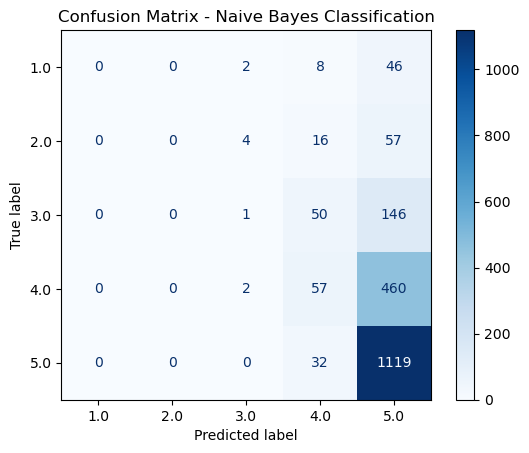

In [235]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, predicted_results)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(classifier, matrix_test, y_test,
                                             cmap=plt.cm.Blues,
                                             values_format='')
disp.ax_.set_title('Confusion Matrix - Naive Bayes Classification')

print(disp.confusion_matrix)

plt.show()


In [236]:
# Importing data
def open_file(filepath):
    with open(filepath) as f:
        return json.load(f)
    


In [262]:
kr_asia = open_file("../data_collection/exports/krasia.json")
today = open_file("../data_collection/exports/today.json")
cna = open_file("../data_collection/exports/cna.json")

In [263]:
news = pd.concat([pd.DataFrame(kr_asia), pd.DataFrame(today), pd.DataFrame(cna)])
news.head()

,title,url,description,date,category,keywords,source
0,“Don’t wait to be approached”: IWD Spotlight w...,https://kr-asia.com/dont-wait-to-be-approached...,The Head of Presales (APAC) at Provenir discus...,2023-03-24T03:01:13+00:00,Q&A,None,krasia
1,Intelligence Indeed and Feiliu Tech named Asia...,https://kr-asia.com/intelligence-indeed-and-fe...,All the participating startups are Chinese com...,2023-03-24T08:13:23+00:00,Events,None,krasia
2,The Importance of Recognition and Community: I...,https://kr-asia.com/the-importance-of-recognit...,The Vice President of Technology Development a...,2023-03-22T06:44:41+00:00,Q&A,None,krasia
3,"Diversity, Education, and Networking: IWD Spot...",https://kr-asia.com/diversity-education-and-ne...,The Head of Tribe Accelerator started out as a...,2023-03-23T08:10:26+00:00,Q&A,None,krasia
4,Indonesia’s GoTo 2022 loss widens to USD 2.6 b...,https://kr-asia.com/indonesias-goto-2022-loss-...,Superapp operator shares now dwelling well bel...,2023-03-23T08:21:02+00:00,News,None,krasia


In [264]:
## Pre-process titles
news['title'] = news['title'].apply(simple_headline_cleaning)
news['title_lemmatized'] = news['title'].apply(tokenization_tagging)
news['title_cleaned'] = news['title_lemmatized'].apply(stopwords_removal)
news.sample(5)

,title,url,description,date,category,keywords,source,title_lemmatized,title_cleaned
17,tencent says its selfdeveloped video transcodi...,https://www.channelnewsasia.com/business/tence...,HONG KONG : Chinese tech giant Tencent Holding...,2023-04-17T18:19:55+08:00,www.channelnewsasia.com,None,cna,tencent say its selfdeveloped video transcodin...,tencent say selfdeveloped video transcoding ch...
6,startup wire shadowboxing,https://kr-asia.com/startup-wire-shadowboxing,The latest startup briefs from across the Asia...,2023-03-25T05:00:05+00:00,Newsletters,None,krasia,startup wire shadowboxing,startup wire shadowboxing
18,freyr battery teams up with siemens on gigafac...,https://www.channelnewsasia.com/business/freyr...,BERLIN : Luxembourg-based Freyr Battery sealed...,2023-04-17T19:03:27+08:00,www.channelnewsasia.com,None,cna,freyr battery team up with siemens on gigafact...,freyr battery team siemens gigafactories
14,chinas electric car drive led by byd leaves gl...,https://www.channelnewsasia.com/business/china...,"SHANGHAI : China's auto market, the world’s la...",2023-04-17T21:03:14+08:00,www.channelnewsasia.com,None,cna,china electric car drive lead by byd leaf glob...,china electric car drive lead byd leaf global ...
16,exnational footballer rafi ali closes his popu...,https://www.todayonline.com//8days/ex-national...,"“We’re sad but life is like that lah, things m...",2023-03-27 22:11:57,,"[Ali Nachia Briyani, Biryani, hawker food, che...",today,exnational footballer rafi ali close his popul...,exnational footballer rafi ali close popular a...


In [265]:
def word_count(string):
    string = string.split(' ')
    return len(string)

def named_entities_extraction(text):
    tokens = nltk.word_tokenize(text)

    # Tag the tokens with part-of-speech (POS) tags
    tagged_tokens = nltk.pos_tag(tokens)

    # Use the named entity chunker to extract named entities
    named_entities = nltk.ne_chunk(tagged_tokens)

    return named_entities

In [266]:
news['headline_word_count'] = news['title'].apply(word_count)
news['named_entities'] = news['title'].apply(named_entities_extraction)

In [267]:
news.head()

,title,url,description,date,category,keywords,source,title_lemmatized,title_cleaned,headline_word_count,named_entities
0,dont wait to be approached iwd spotlight with ...,https://kr-asia.com/dont-wait-to-be-approached...,The Head of Presales (APAC) at Provenir discus...,2023-03-24T03:01:13+00:00,Q&A,None,krasia,dont wait to be approach iwd spotlight with me...,dont wait approach iwd spotlight mei ye,10,"[(dont, JJ), (wait, NN), (to, TO), (be, VB), (..."
1,intelligence indeed and feiliu tech named asia...,https://kr-asia.com/intelligence-indeed-and-fe...,All the participating startups are Chinese com...,2023-03-24T08:13:23+00:00,Events,None,krasia,intelligence indeed and feiliu tech name asia ...,intelligence indeed feiliu tech name asia star...,20,"[(intelligence, NN), (indeed, RB), (and, CC), ..."
2,the importance of recognition and community iw...,https://kr-asia.com/the-importance-of-recognit...,The Vice President of Technology Development a...,2023-03-22T06:44:41+00:00,Q&A,None,krasia,the importance of recognition and community iw...,importance recognition community iwd spotlight...,12,"[(the, DT), (importance, NN), (of, IN), (recog..."
3,diversity education and networking iwd spotlig...,https://kr-asia.com/diversity-education-and-ne...,The Head of Tribe Accelerator started out as a...,2023-03-23T08:10:26+00:00,Q&A,None,krasia,diversity education and networking iwd spotlig...,diversity education networking iwd spotlight r...,9,"[(diversity, NN), (education, NN), (and, CC), ..."
4,indonesias goto 2022 loss widens to usd 26 bil...,https://kr-asia.com/indonesias-goto-2022-loss-...,Superapp operator shares now dwelling well bel...,2023-03-23T08:21:02+00:00,News,None,krasia,indonesia goto 2022 loss widen to usd 26 billion,indonesia goto 2022 loss widen usd 26 billion,9,"[(indonesias, NNS), (goto, JJ), (2022, CD), (l..."


In [268]:
## Applying classifier
news_matrix = vectorizer.transform(news['title_cleaned'])
news_results = classifier.predict(news_matrix)
news['rating'] = news_results
news.head()

,title,url,description,date,category,keywords,source,title_lemmatized,title_cleaned,headline_word_count,named_entities,rating
0,dont wait to be approached iwd spotlight with ...,https://kr-asia.com/dont-wait-to-be-approached...,The Head of Presales (APAC) at Provenir discus...,2023-03-24T03:01:13+00:00,Q&A,None,krasia,dont wait to be approach iwd spotlight with me...,dont wait approach iwd spotlight mei ye,10,"[(dont, JJ), (wait, NN), (to, TO), (be, VB), (...",5.0
1,intelligence indeed and feiliu tech named asia...,https://kr-asia.com/intelligence-indeed-and-fe...,All the participating startups are Chinese com...,2023-03-24T08:13:23+00:00,Events,None,krasia,intelligence indeed and feiliu tech name asia ...,intelligence indeed feiliu tech name asia star...,20,"[(intelligence, NN), (indeed, RB), (and, CC), ...",4.0
2,the importance of recognition and community iw...,https://kr-asia.com/the-importance-of-recognit...,The Vice President of Technology Development a...,2023-03-22T06:44:41+00:00,Q&A,None,krasia,the importance of recognition and community iw...,importance recognition community iwd spotlight...,12,"[(the, DT), (importance, NN), (of, IN), (recog...",4.0
3,diversity education and networking iwd spotlig...,https://kr-asia.com/diversity-education-and-ne...,The Head of Tribe Accelerator started out as a...,2023-03-23T08:10:26+00:00,Q&A,None,krasia,diversity education and networking iwd spotlig...,diversity education networking iwd spotlight r...,9,"[(diversity, NN), (education, NN), (and, CC), ...",5.0
4,indonesias goto 2022 loss widens to usd 26 bil...,https://kr-asia.com/indonesias-goto-2022-loss-...,Superapp operator shares now dwelling well bel...,2023-03-23T08:21:02+00:00,News,None,krasia,indonesia goto 2022 loss widen to usd 26 billion,indonesia goto 2022 loss widen usd 26 billion,9,"[(indonesias, NNS), (goto, JJ), (2022, CD), (l...",5.0


## Description of final table

In [269]:
news.shape

(50, 12)

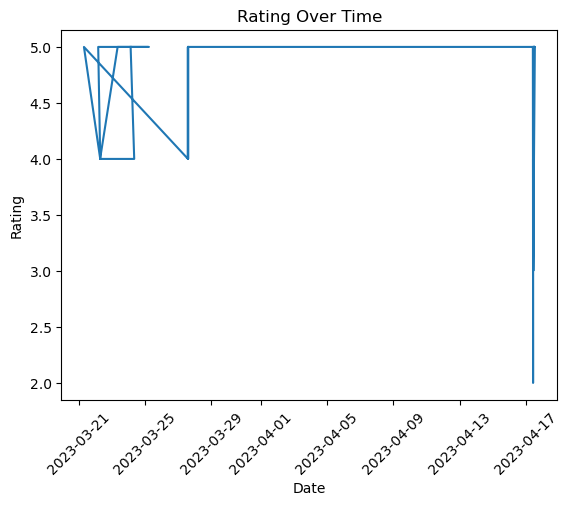

In [270]:
# Convert the date column to a datetime object and set timezone information
news['date'] = pd.to_datetime(news['date'])

# Create the line chart
fig, ax = plt.subplots()
ax.plot(news['date'], news['rating'])

# Format the x-axis labels
date_form = DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(date_form)
plt.xticks(rotation=45)

# Add axis labels and title
plt.xlabel('Date')
plt.ylabel('Rating')
plt.title('Rating Over Time')

# Show the chart
plt.show()


In [ ]:
news.groupby('source')['rating'].mean().plot(kind='bar',color=['red','green','blue'])


In [225]:
import json
import pandas as pd
from processing import tokenization_tagging, stopwords_removal, simple_headline_cleaning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import nltk
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, confusion_matrix